# 1. Introduction

The model uses FER-2013 dataset for Face Emotion Recognition (https://datarepository.wolframcloud.com/resources/FER-2013).

Link to the reference research paper used in this notebook:
https://ieeexplore.ieee.org/document/7477450

# 2. Importing the libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, SeparableConv2D
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, SeparableConv2D, ZeroPadding2D, UpSampling2D, BatchNormalization, Input, GlobalAveragePooling2D, AveragePooling2D

from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from keras import backend as K
from keras.models import Sequential, Model, load_model, model_from_json

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import h5py
from keras.models import model_from_json
import pickle
import os

# 3. Importing data from drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
X_train = np.load("drive/MyDrive/EmotionVideoModel/X_train.npy")
X_test = np.load("drive/MyDrive/EmotionVideoModel/X_test.npy")
y_train = np.load("drive/MyDrive/EmotionVideoModel/y_train.npy")
y_test = np.load("drive/MyDrive/EmotionVideoModel/y_test.npy")

In [ ]:
print (X_train.shape)
print (X_test.shape)

(28709, 48, 48, 1)
(3589, 48, 48, 1)


In [ ]:
shape_x = 48
shape_y = 48
nRows,nCols,nDims = X_train.shape[1:]
input_shape = (nRows, nCols, nDims)
classes = np.unique(y_train)
nClasses = len(classes)

In [ ]:
dic = { 0: "Angry",
       1: "Disgust",
       2:"Fear",
       3:"Happy",
       4:"Sad",
       5:"Surprise",
       6:"Neutral"}

# 4. CNN model for emotion recognition

##a) Creating the model

2D CNN model that uses Conv, BatchNorm, MaxPooling layers. Dropout and EarlyStoppng is used to prevent overfitting

In [ ]:
input_shape = (48, 48, 1)
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_shape))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(7, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 256)       2

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

batch_size = 64
epochs = 200

datagen = ImageDataGenerator(
        zoom_range=0.20,          
        rotation_range=20,      
        width_shift_range=0.20,   
        height_shift_range=0.20,   
        vertical_flip=True)     

earlyStopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=0, mode='max')

if (os.path.exists("weights")==False):
  os.mkdir("weights")

filepath ="weights/weights-{epoch:02d}-{val_accuracy:.2f}.hdf5"
model_checkpoint = tensorflow.keras.callbacks.ModelCheckpoint(filepath,
    monitor='val_accuracy',
    mode='max',
    save_weights_only=True,
    save_best_only=True)

history = model.fit(
    X_train, y_train,
    epochs = epochs,
    callbacks=[earlyStopping, model_checkpoint],
    validation_data=(X_test, y_test))


Epoch 1/200
898/898 [==============================] - 26s 21ms/step - loss: 6.9324 - accuracy: 0.2320 - val_loss: 1.6735 - val_accuracy: 0.3165
Epoch 2/200
898/898 [==============================] - 18s 20ms/step - loss: 1.7333 - accuracy: 0.2925 - val_loss: 1.6174 - val_accuracy: 0.3550
Epoch 3/200
898/898 [==============================] - 18s 21ms/step - loss: 1.6451 - accuracy: 0.3377 - val_loss: 1.5287 - val_accuracy: 0.4065
Epoch 4/200
898/898 [==============================] - 19s 21ms/step - loss: 1.5885 - accuracy: 0.3630 - val_loss: 1.5005 - val_accuracy: 0.4296
Epoch 5/200
898/898 [==============================] - 19s 21ms/step - loss: 1.5334 - accuracy: 0.3892 - val_loss: 1.4446 - val_accuracy: 0.4416
Epoch 6/200
898/898 [==============================] - 19s 21ms/step - loss: 1.4917 - accuracy: 0.4138 - val_loss: 1.5003 - val_accuracy: 0.4283
Epoch 7/200
898/898 [==============================] - 19s 21ms/step - loss: 1.4630 - accuracy: 0.4294 - val_loss: 1.3910 - val_ac

##c) Plotting the accuracy and loss graphs

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


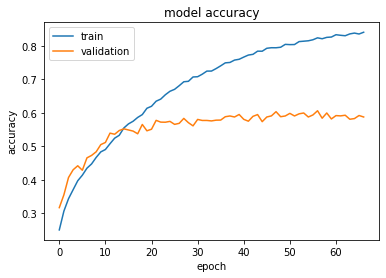

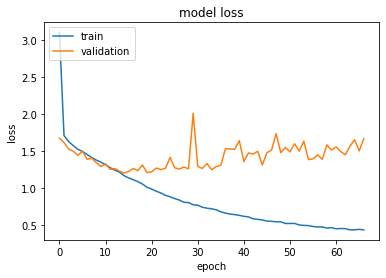

In [ ]:
# model

print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

##d) Saving the model and weights

In [ ]:
model_json = model.to_json()

with open("model_num.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model_num.h5")

json_file = open('model_num.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("model_num.h5")
print("Loaded model from disk")

loaded_model.save('model_num.hdf5')

Loaded model from disk


##e) Predicting the test data from the model

In [ ]:

pred_ = model.predict(X_test.reshape(-1, shape_x, shape_y, 1))

pred_[0]

# accuracy_score(y_test, pred_)
pred_ = np.argmax(pred_, axis=1)
y_test_ = np.argmax(y_test, axis=1)

print (y_test_.shape)
count = 0;
for i in range (len(y_test_)):
  if y_test_[i]==pred_[i]:
    count+=1
print (count/len(y_test_))

(3589,)
0.5873502368347729
